In this notebook, I will use fastai2 library to create and train a Convolutional Neural Network.

# Importing libraries

In [ ]:
#hide 
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


     |████████████████████████████████| 727kB 12.2MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 194kB 29.3MB/s 
     |████████████████████████████████| 1.1MB 30.9MB/s 
     |████████████████████████████████| 51kB 9.6MB/s 
     |████████████████████████████████| 40kB 8.1MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
     |████████████████████████████████| 2.6MB 54.4MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *
import seaborn as sns
from fastai.vision import * 
from sklearn.model_selection import train_test_split
from fastai.callback.all import *

# Loading Dataset 

In [ ]:
data = pd.read_csv('gdrive/My Drive/age_gender.csv', delimiter=',')

In [ ]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

Total rows: 23705
Total columns: 5


In [ ]:
data.head(1)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 149 147 145 146 147 148 149 149 150 153 153 153 152 153 153 153 153 153 151 149 147 146 146 144 143 140 134 129 129 126 122 121 119 118 118 99 53 130 129 128 126 127 130 135 141 143 143 144 145 143 142 144 145 146 149 149 148 151 151 151 151 152 153 153 153 153 149 148 147 146 146 142 141 138 133 130 130 128 123 124 122 120 117 98 52 131 129 130 129 129 134 138 144 145 143 143 139 140 138 139 140 142 145 147 149 151 149 149 149 151 152 151 150 150 148 147 145 144 142 140 137 136 135 134 131 128 126 126 123 122 114 97 50 135 134 133 132 131 136 14...


In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


# Distributions 

So, there are three targets:

*  Age: range from 1 to 116
* Ethnicity: 0 - White, 1 - Black, 2 - Asian, 3 - Indian, 4 - Other
* Gender: 0 - male, 1 - female 



In [ ]:
import plotly.graph_objects as go
## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

##Age distribution

In [ ]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

##Ethnicity distribution

In [ ]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

## Gender Distribution

In [ ]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

# Data preparation

Before I can feed "pixels" to my Convolution network:

*   Pixels are saved as one long String separated with spaces, I need to transform every 1D 2048 to 2D 48 x 48 (CNN requirement), also I need to add one more dimension(Pytorch requirement)   
*   Split data into training and validation set (Neural network requirement)
*   Convert training and validation set to tensors (Pytorch requirement, performance benefit)
*   Put training and validation set into TensorDataset (Pytorch requirement)
*   Put TensorDatasets into TransformedDataLoaders and wrap it using DataLoaders


In [ ]:
# multiple rows with one long string(2304 numbers) separated with spaces, 
X=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))/255.0 #normalization

X = np.stack(np.array(X), axis=0)
X = np.reshape(X, (-1, 48, 48))
X = np.expand_dims(X, axis=1)

X.shape

(23705, 1, 48, 48)

In [ ]:
# y = data['age'].values
y=data['ethnicity'].values
# y = data['gender'].values

x_train, x_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.15
)

In [ ]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train)
# y_train = y_train.squeeze()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid)
# y_valid = y_valid.squeeze()

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(y_valid)

torch.Size([20149, 1, 48, 48])
torch.Size([20149])
torch.Size([3556, 1, 48, 48])
torch.Size([3556])
tensor([1, 1, 4,  ..., 0, 3, 0])


In [ ]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [ ]:
BATCH_SIZE = 32

train_dl = TfmdDL(train_ds, bs=BATCH_SIZE, shuffle=False)
valid_dl = TfmdDL(valid_ds, bs=2*BATCH_SIZE)

xb,yb = first(train_dl)
xb.shape,yb.shape

(torch.Size([32, 1, 48, 48]), torch.Size([32]))

# Sample images

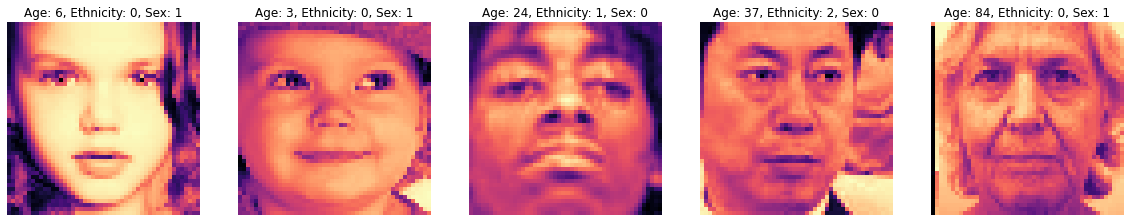

In [ ]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(data))
    
    age = data['age'][random_face]
    ethnicity = data['ethnicity'][random_face]
    gender = data['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(X[random_face][0], cmap=plt.get_cmap('magma'))
    axes[i].axis('off')

# df = pd.DataFrame(x_valid[0][0])
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')
# show_image(x_valid[100][0], figsize=(2,2), title="Age:"+str(data['age'].iloc[i])+" Ethnicity:"+str(data['ethnicity'].iloc[i])+" Gender:"+ str(data['gender'].iloc[i]))

In [ ]:
if torch.cuda.is_available():
    dls = DataLoaders(train_dl, valid_dl).cuda()
else:
    dls = DataLoaders(train_dl, valid_dl)

# Model

## Model definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#
# popis cnn https://www.kaggle.com/androbomb/using-cnn-to-classify-images-w-pytorch
class Mnist_NN(nn.Module):
    def __init__(self):
        super(Mnist_NN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # notice the padding
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # again...
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # again...
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1) # again...
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(64*6*6, 256) # it is 64....
        self.fc2 = nn.Linear(256, 10)
        self.dropout = torch.nn.Dropout(p=0.1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))       

        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv3(x)))        
        
        x = F.relu(self.conv4(x))      
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.dropout(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 6 * 6 * 64)
        # Feed to fully-connected layer to predict class
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # Return class probabilities via a log_softmax function 
        return x

In [ ]:
# Check if model parameters have been set correctly

from torchsummary import summary


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Mnist_NN().float().to(device)
summary(model, input_size=(1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
         MaxPool2d-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5          [-1, 128, 12, 12]          73,856
         MaxPool2d-6            [-1, 128, 6, 6]               0
            Conv2d-7             [-1, 64, 6, 6]          73,792
           Dropout-8             [-1, 64, 6, 6]               0
            Linear-9                  [-1, 256]         590,080
           Linear-10                   [-1, 10]           2,570
Total params: 759,114
Trainable params: 759,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.27
Params size (MB): 2.90
Estimated T

## Model training



In [ ]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Mnist_NN().float()
model.to(device)
learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy, opt_func=SGD)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.9120108485221863)

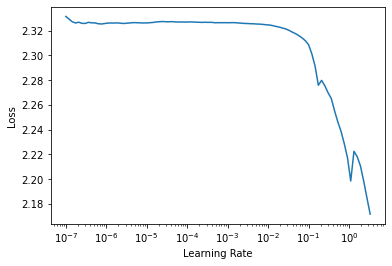

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.model_dir = "/kaggle/working"

# if GPU enabled:
if torch.cuda.is_available():
    learn.model.cuda()

# learn.fit_one_cycle(10, 5e-2, callbacks=[SaveModelCallback(every='improvement', 
#                                         monitor='validation_loss', name='best_saved')])
learn.fit_one_cycle(10, 0.06)

epoch,train_loss,valid_loss,accuracy,time
0,0.362282,0.626353,0.790495,00:05
1,0.439787,0.650647,0.774184,00:05
2,0.450446,0.636565,0.778965,00:05
3,0.409793,0.689015,0.770529,00:05
4,0.395447,0.688681,0.760405,00:05
5,0.333067,0.648882,0.788526,00:05
6,0.304602,0.683504,0.779246,00:05
7,0.279944,0.674012,0.790495,00:05
8,0.247683,0.674237,0.793588,00:05
9,0.249626,0.662925,0.792745,00:05


In [ ]:
# learn.save(file = '/content/gdrive/My Drive/learner')

Path('/content/gdrive/My Drive/learner.pth')

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=9.12010818865383e-07)

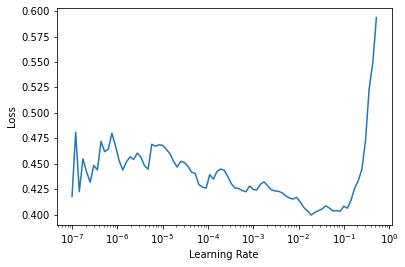

In [ ]:
learn.lr_find()

## Model testing

In [ ]:
valid_ds = TensorDataset(x_valid, y_valid)

In [ ]:
print(x_valid.shape)
print(y_valid.shape)

torch.Size([3556, 1, 48, 48])
torch.Size([3556])


In [ ]:
# Submit to kaggle:
if torch.cuda.is_available():
    X_test = x_valid.float().cuda()
else:
    X_test = torch.from_numpy(x_valid).float()
  
print(X_test.shape[0])
learn.freeze()

# yp = np.zeros((3555 ,2), dtype='int')
# for i in range(0, 3555, 5):
#     prob_sum = torch.argmax(F.softmax(learn.model(X_test[i:i+5]), dim=1), dim=1).cpu().numpy()
#     yp[i:i+5] = np.array(np.vstack([np.arange(i+1, i+5+1), prob_sum]).T)

yp = np.zeros((X_test.shape[0] ,2), dtype='int')
for i in range(0, X_test.shape[0], 1):
    prob_sum = torch.argmax(learn.model(X_test[i:i+1]), dim=1).cpu().numpy()
    yp[i:i+1] = np.array(np.vstack([np.arange(i+1, i+1+1), prob_sum]).T)

    
res = pd.DataFrame(yp, index = np.arange(len(yp)), columns=["ImageId", "Pred_gen"])
res.to_csv("submission.csv", index=False)
res

3556


,ImageId,Pred_gen
0,1,4
1,2,1
2,3,1
3,4,3
4,5,0
...,...,...
3551,3552,4
3552,3553,1
3553,3554,0
3554,3555,3


In [ ]:
res.Pred_gen.agg(['count', 'size', 'nunique'])
res.Pred_gen.value_counts()

0    1610
1     669
3     629
2     506
4     142
Name: Pred_gen, dtype: int64

In [ ]:
new_results=res.copy()
new_results.insert(2, "Real_gen", y_valid, True) 

In [ ]:
print(res)
print(new_results)

      ImageId  Pred_gen
0           1         4
1           2         1
2           3         1
3           4         3
4           5         0
...       ...       ...
3551     3552         4
3552     3553         1
3553     3554         0
3554     3555         3
3555     3556         0

[3556 rows x 2 columns]
      ImageId  Pred_gen  Real_gen
0           1         4         1
1           2         1         1
2           3         1         4
3           4         3         4
4           5         0         0
...       ...       ...       ...
3551     3552         4         3
3552     3553         1         1
3553     3554         0         0
3554     3555         3         3
3555     3556         0         0

[3556 rows x 3 columns]


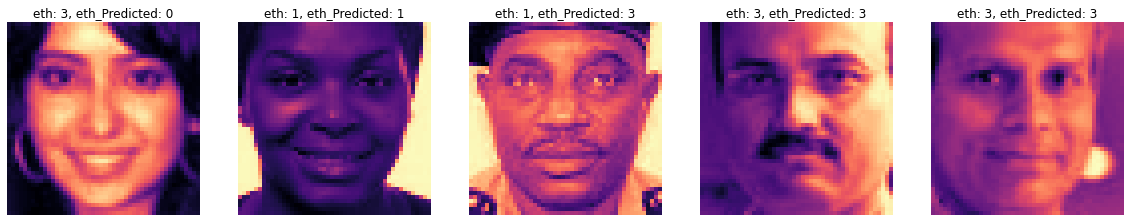

In [ ]:
# cannot use gpu when drawing pictures like this
X_test = Tensor.cpu(X_test)

# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(y_valid))
    
    gender_real = y_valid[random_face]
    gender_predicted = pd.DataFrame.to_numpy(res)[:, -1][random_face]
    
    axes[i].set_title('eth: {0}, eth_Predicted: {1}'.format(gender_real,gender_predicted))
    axes[i].imshow(x_valid[random_face][0], cmap=plt.get_cmap('magma'))
    axes[i].axis('off')

# df = pd.DataFrame(x_valid[0][0])
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')
# show_image(x_valid[100][0], figsize=(2,2), title="Age:"+str(data['age'].iloc[i])+" Ethnicity:"+str(data['ethnicity'].iloc[i])+" Gender:"+ str(data['gender'].iloc[i]))